In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

2023-08-01 07:41:55.416462: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
channels=3
EPOCHS=50

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("patato_disease",
                                                            shuffle=True,
                                                   image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                   batch_size=BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


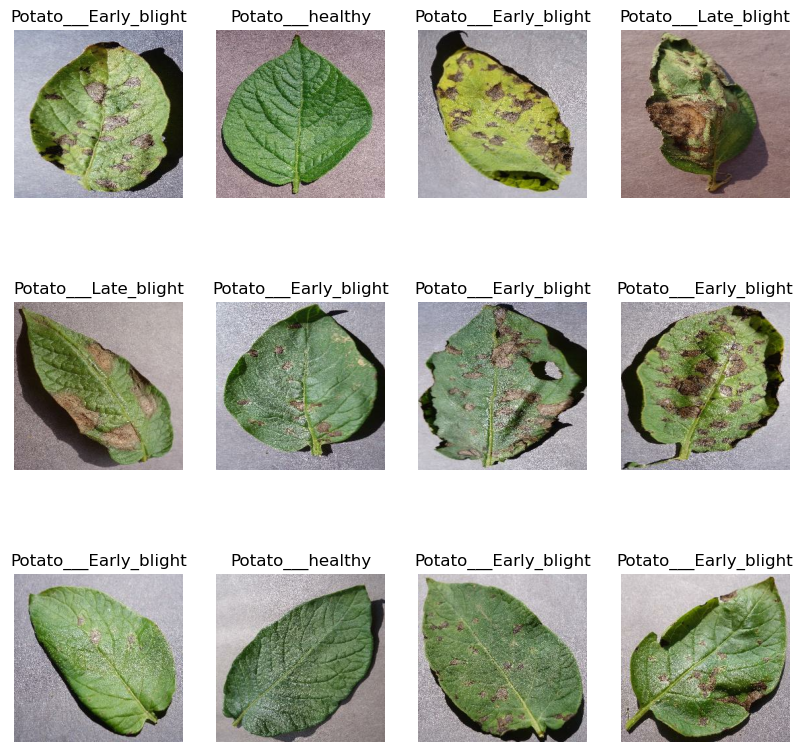

In [7]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
  

In [9]:
#spliting
#80% -> training
#20% -> 10%-> validation, 10% ->test

In [10]:
train_ds=dataset.take(54)
len(train_ds)

54

In [11]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [12]:
val_ds=test_ds.take(6)

In [13]:
test_ds=test_ds.skip(6)

In [14]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    
    
    return train_ds,val_ds,test_ds

In [15]:
train_ds,val_ds,test_ds =get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

54

In [17]:
len(val_ds)

6

In [18]:
len(test_ds)

8

In [19]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
#SCALLING

In [21]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [22]:
# data augumentation
data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    
])

In [23]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,channels)
n_classes=3

model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    #cnn
    layers.Conv2D(32,kernel_size=(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    
    #dense
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(n_classes,activation="softmax")
        
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [25]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [26]:
history=model.fit(train_ds,epochs=10,
         batch_size=BATCH_SIZE,
         verbose=1,
         validation_data=val_ds)

Epoch 1/10
54/54 [==============================] - 79s 1s/step - loss: 0.7841 - accuracy: 0.6505 - val_loss: 0.5160 - val_accuracy: 0.8281
Epoch 2/10
54/54 [==============================] - 73s 1s/step - loss: 0.4359 - accuracy: 0.8478 - val_loss: 0.2963 - val_accuracy: 0.8854
Epoch 3/10
54/54 [==============================] - 158s 3s/step - loss: 0.3146 - accuracy: 0.8773 - val_loss: 0.1614 - val_accuracy: 0.9531
Epoch 4/10
54/54 [==============================] - 70s 1s/step - loss: 0.2218 - accuracy: 0.9080 - val_loss: 0.1919 - val_accuracy: 0.9323
Epoch 5/10
54/54 [==============================] - 118s 2s/step - loss: 0.1604 - accuracy: 0.9363 - val_loss: 0.0939 - val_accuracy: 0.9583
Epoch 6/10
54/54 [==============================] - 68s 1s/step - loss: 0.1845 - accuracy: 0.9323 - val_loss: 0.2067 - val_accuracy: 0.9323
Epoch 7/10
54/54 [==============================] - 377s 7s/step - loss: 0.1636 - accuracy: 0.9410 - val_loss: 0.1023 - val_accuracy: 0.9583
Epoch 8/10
54/54 

In [27]:
model.evaluate(test_ds)

8/8 [==============================] - 5s 346ms/step - loss: 0.0536 - accuracy: 0.9805


[0.05364888161420822, 0.98046875]

In [28]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [39]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]

Text(0.5, 1.0, 'Training and validation loss')

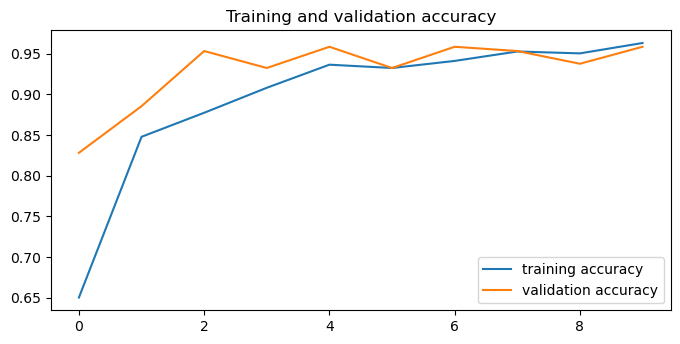

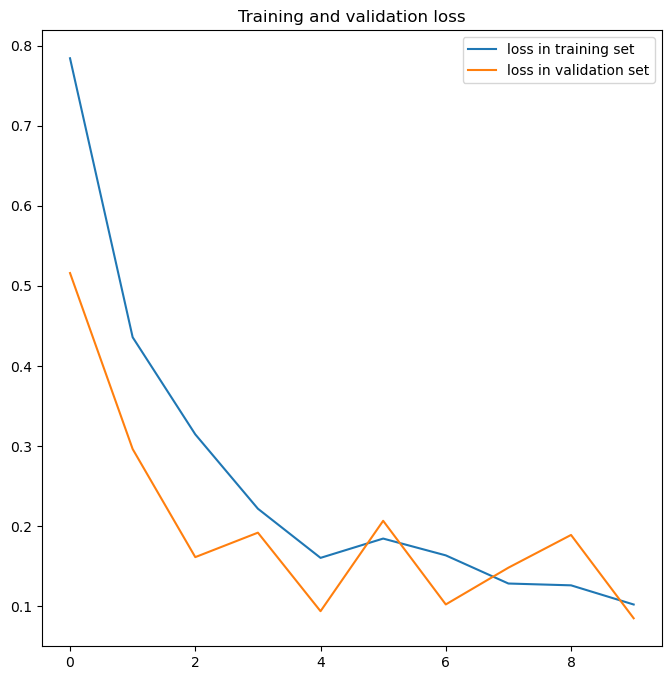

In [45]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(range(10),acc,label="training accuracy")
plt.plot(range(10),val_acc,label="validation accuracy")
plt.legend(loc="lower right")
plt.title("Training and validation accuracy")




plt.figure(figsize=(8,8))
plt.plot(range(10),loss,label="loss in training set")
plt.plot(range(10),val_loss,label="loss in validation set")
plt.legend(loc="upper right")
plt.title("Training and validation loss")




first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 574ms/step
predicted_label: Potato___Early_blight


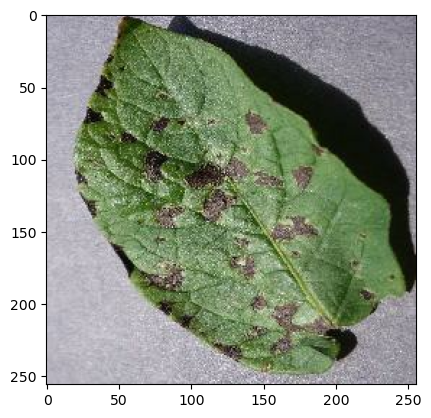

In [83]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype("uint8")
    first_label=labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction=model.predict(images_batch)
    print("predicted_label:",class_names[np.argmax(batch_prediction[0])])

In [86]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(batch_prediction[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 27ms/step


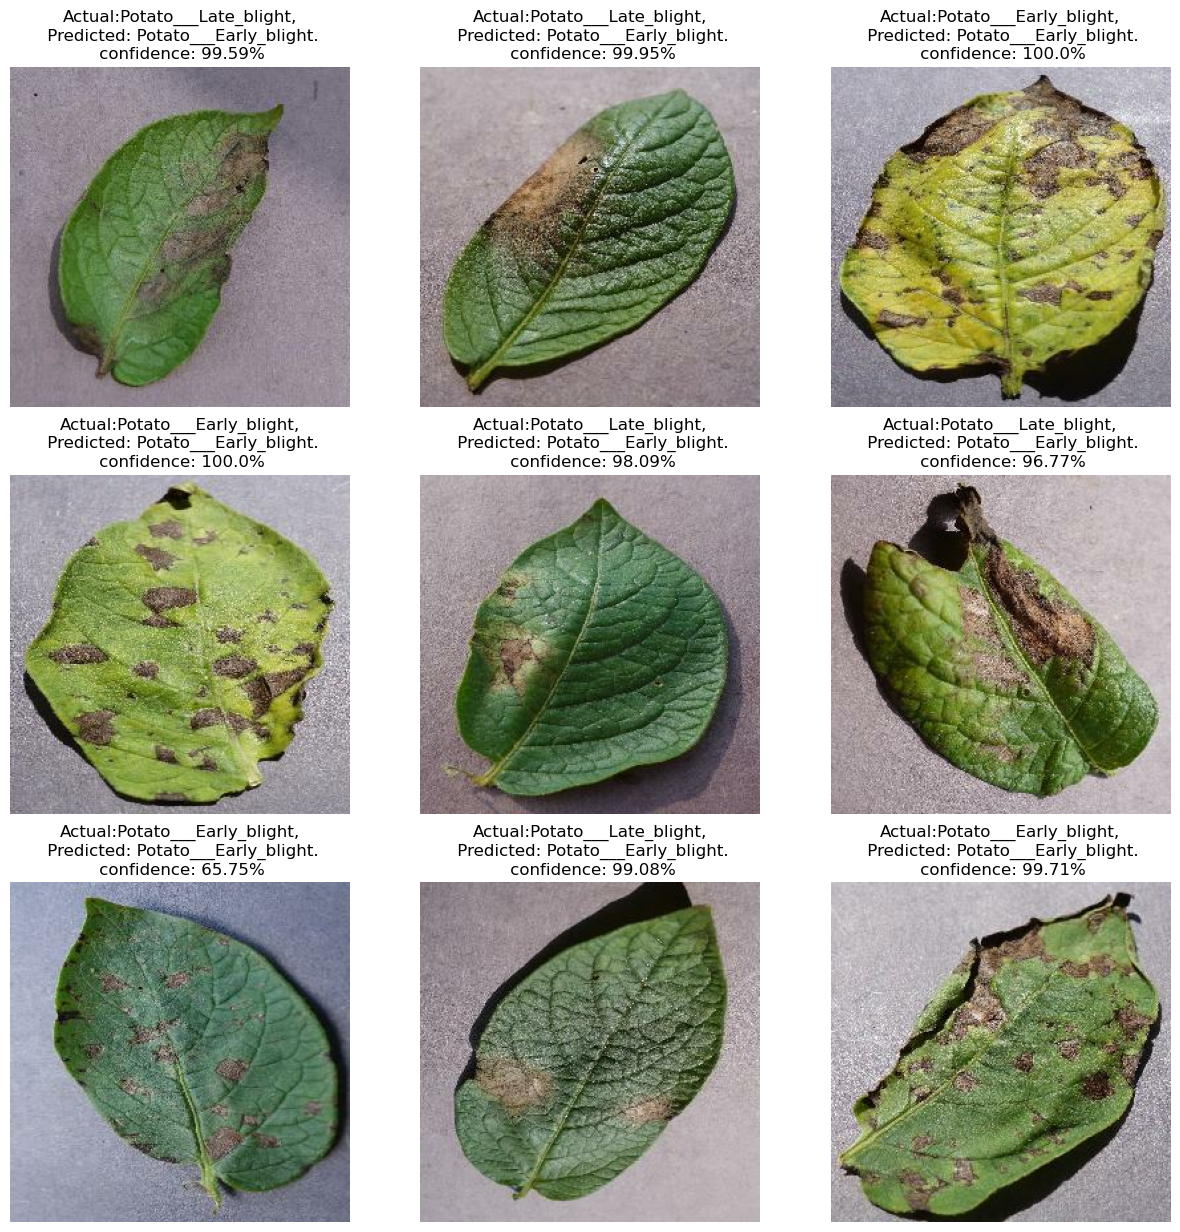

In [87]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class}.\n confidence: {confidence}%")
        plt.axis("off")

In [70]:
model_version=2
model.save(f"../models_patato_disease/{model_version}")

INFO:tensorflow:Assets written to: ../models_patato_disease/2/assets


INFO:tensorflow:Assets written to: ../models_patato_disease/2/assets


In [74]:
img_array=tf.keras.preprocessing.image.img_to_array(images[0].numpy())

(256, 256, 3)